In [1]:
#library('DESeq2')
library('MASS')
library('tidyverse')
library('anomalize')
library('kohonen')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
══ Use anomalize to improve your Forecasts by 50%! ═════════════════════════════
Business Science offers a 1-hour course - Lab #18: Time Series Anomaly Detection!
</> Learn more at: https://university.business-science.io/p/learning-labs-pro </>

Attaching package: ‘kohonen’

The following object is masked from ‘package:purrr’:

    map



In [2]:
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('orchid1', 'purple1', 'darkorchid4')
i_palette <- c('grey', 'lightblue', 'darkblue')
t_palette <- c('darkgreen', 'mediumpurple4')
b_palette <- c('#ffd4a3', '#ffaa5e', '#d08159')
y_palette <- c('dodgerblue4', 'springgreen1', '#cc77ff')#'#f0b4d2')
r_palette <- viridisLite::viridis(9)

In [3]:
treatments <- read.csv('1719_treatments.csv')
load('1719_VSD_counts_varFilt.Rdata')

In [4]:
treatments$Rootstock <- factor(treatments$Rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))
treatments$Irrigation <- factor(treatments$Irrigation, levels=c('None', 'RDI', 'Full'))
treatments$Phenology <- factor(treatments$Phenology, levels=c('Anthesis', 'Veraison', 'Harvest'))
treatments$Tissue <- factor(treatments$Tissue, levels=c('Leaf', 'Reproductive'))
treatments$Row <- as.factor(treatments$Row)
treatments$Year <- as.factor(treatments$Year)

In [78]:
dim(vsd_counts_varFilt)

[1]  1178 24392

## Create Extract Top Var Genes, for now

In [43]:
# #top var genes for trial and error
# geneVar <- apply(vsd_counts_varFilt, 2, sd)
# quants <- quantile(geneVar, probs=seq(0, 1, 0.01))

# cutoff75 <- as.double(quants['50%'])

# geneVar_filt = rep(FALSE, length(geneVar))
# geneVar_filt[geneVar > cutoff75] <- TRUE
# sum(geneVar_filt)

# vsd75 <- vsd_counts_varFilt[,geneVar_filt]
# vsd_counts_scaled <- as.data.frame(t(scale(vsd75, center=T, scale=T)))

[1] 11062

## Genes Significant for Phenology:Tissue

In [5]:
#loads genes_for_SOM_YearPhenology
load('1719_genes_for_SOM_PVE_phenologyTissue.Rdata')

In [6]:
vsdPT <- vsd_counts_varFilt[,genes_for_SOM_PVE_phenologyTissue]
vsd_counts_scaled <- as.data.frame(t(scale(vsdPT, center=T, scale=T)))

ERROR: Error in `[.data.frame`(vsd_counts_varFilt, , genes_for_SOM_PVE_phenologyTissue): object 'genes_for_SOM_PVE_phenologyTissue' not found


### Vizualize in PC Space

[1] 17738  1178

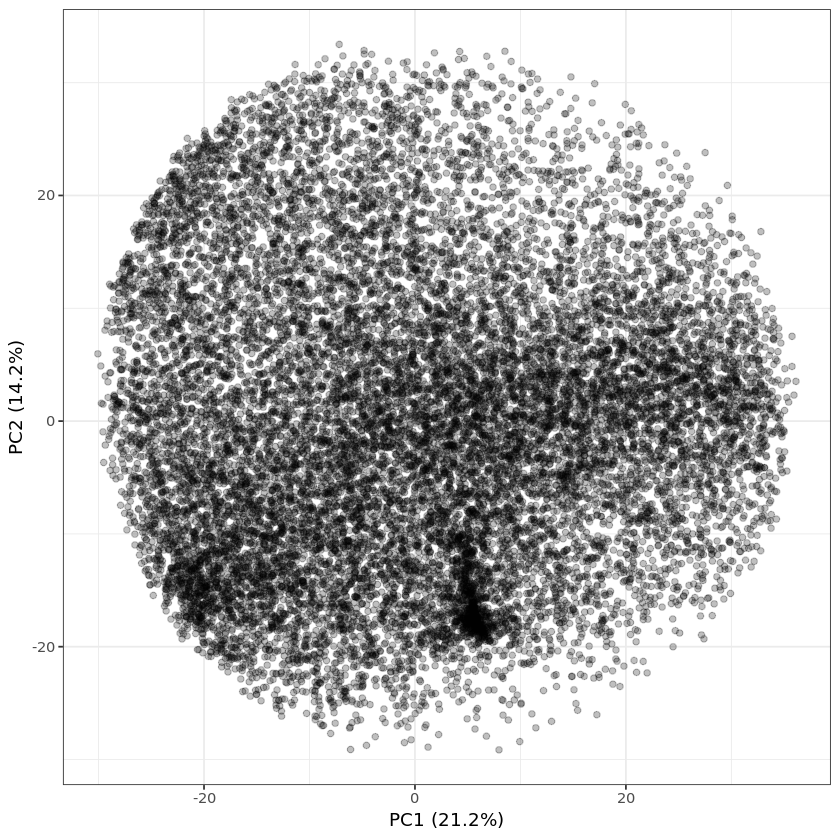

In [226]:
pca <- prcomp(vsd_counts_scaled)
x <- as.data.frame(pca$x)
#summary(pca)
dim(x)

ggplot(x, aes(x=PC1, y=PC2)) + 
  geom_point(alpha=0.25) + 
  xlab("PC1 (21.2%)") + 
  ylab("PC2 (14.2%)") + 
  theme_bw()

### Compute SOM

In [62]:
sqrt(5*sqrt(dim(x)[1]))

[1] 19.25205

In [227]:
grid <- somgrid(4,4, 'hexagonal')
geneExpression_SOM <- som(as.matrix(vsd_counts_scaled), grid=grid, rlen=500, alpha=c(0.05, 0.01))

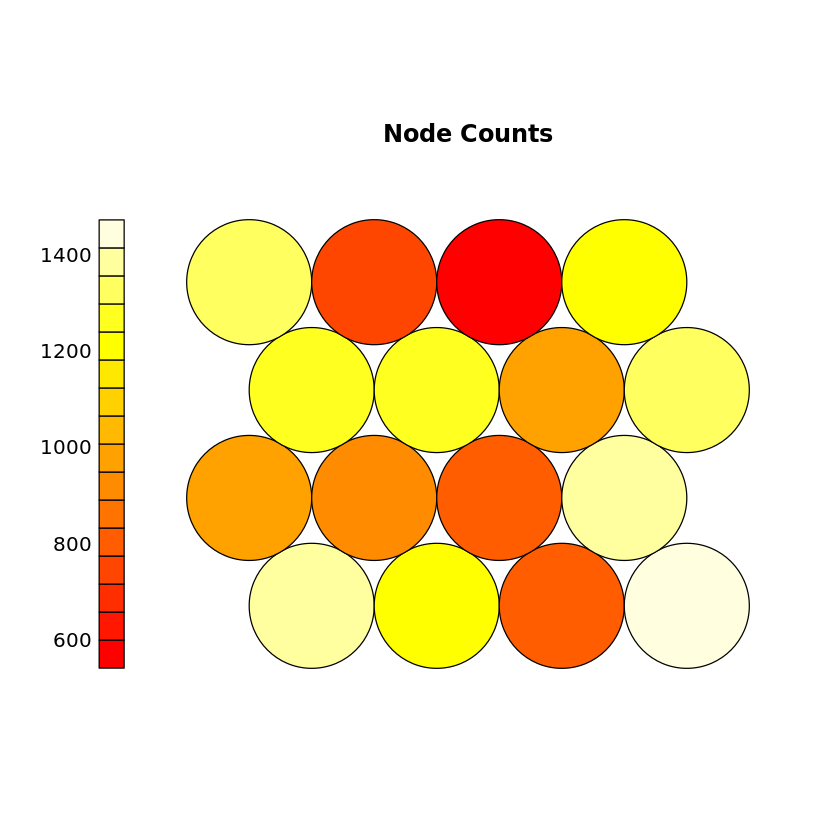

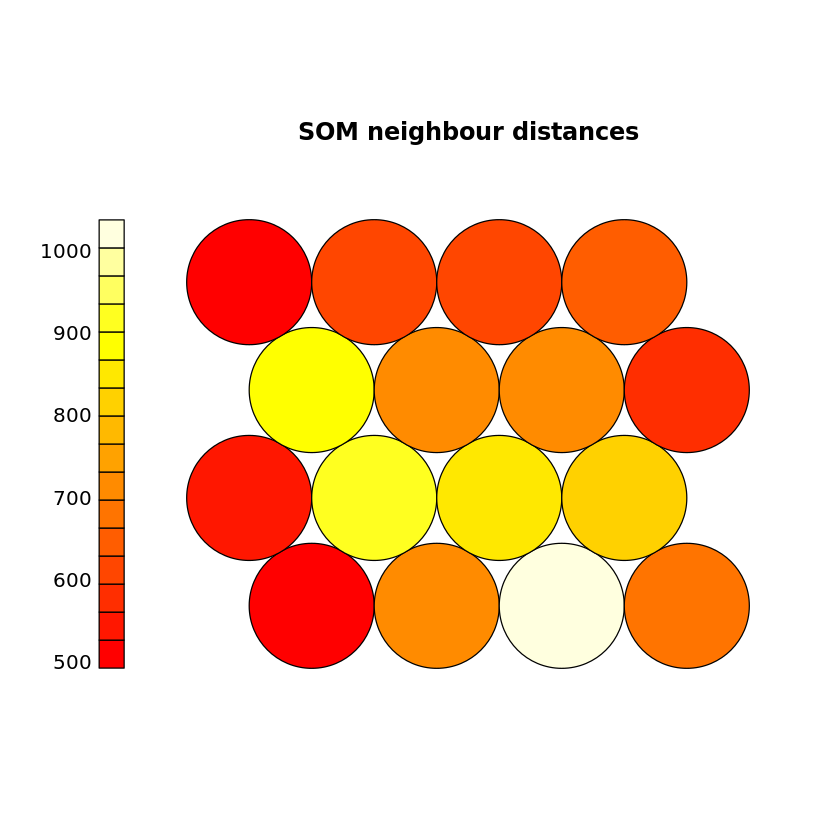

In [228]:
plot(geneExpression_SOM, type="count", main="Node Counts")
plot(geneExpression_SOM, type="dist.neighbours", main = "SOM neighbour distances")

In [229]:
# # stolen from https://iamciera.github.io/SOMexample/html/SOM_RNAseq_tutorial_part2a_SOM.html

# # use hierarchical clustering to cluster the codebook vectors
# som_cluster <- cutree(hclust(dist(geneExpression_SOM$codes[[1]])), 16)

# # plot these results:
# plot(geneExpression_SOM, type="mapping", bgcol = som_cluster, main = "Clusters", pch=NA) 
# add.cluster.boundaries(geneExpression_SOM, som_cluster) 

In [230]:
# # stolen from https://iamciera.github.io/SOMexample/html/SOM_RNAseq_tutorial_part2a_SOM.html

# # Attach the hierchal cluster to the larger dataset data.val.
# som_clusterKey <- data.frame(som_cluster)
# som_clusterKey$unit.classif <- c(1:36)

# d <- cbind(x,geneExpression_SOM$unit.classif,geneExpression_SOM$distances)
# head(x)

# names(d)[1179] <- "unit.classif"

# d$gene <- rownames(d)
# d <- merge(d, som_clusterKey, by.x = "unit.classif" )
# head(d)

In [231]:
# ggplot(d, aes(x=PC1, y=PC2, color=factor(som_cluster))) + 
#   geom_point(alpha=0.25) + 
#   xlab("PC1 (21.2%)") + 
#   ylab("PC2 (14.2%)") + 
#   theme_bw() + 
#   theme(legend.position="none")

In [232]:
# # Dan (I think) only included genes whose distance to their node was < the median of all distances. 

# percentile_distance <-  quantile(d$`geneExpression_SOM$distances`, probs=seq(0, 1, 0.01))[['50%']]
# percentile_distance <- as.double(percentile_distance)

# for_plot <- d[d$`geneExpression_SOM$distances` < percentile_distance,]
# dim(for_plot)

# ggplot(for_plot, aes(x=PC1, y=PC2, color=factor(som_cluster))) + 
#   geom_point(alpha=0.25) + 
#   xlab("PC1 (22.1%)") + 
#   ylab("PC2 (14.5%)") +
#   theme_bw() + 
#   theme(legend.position="none")

In [126]:
colnames(line_plot_wide[2])
colnames(line_plot_wide[length(line_plot_wide)-3])

[1] "Vitvi00g00444"

[1] "Vitvi19g02388"

In [233]:
# #use for_plot for dist < median; use d for all
# line_plot_mapping <- data.frame(gene=for_plot$gene, cluster=for_plot$som_cluster)
# line_plot_wide <- as.data.frame(scale(vsdPT, center=T, scale=T))
# line_plot_wide$sampleName <- rownames(line_plot_wide)
# line_plot_wide <- merge(line_plot_wide, select(treatments, sampleName, Phenology, Tissue), by='sampleName')
# line_plot_wide$PT <- paste(line_plot_wide$Phenology, line_plot_wide$Tissue, sep='_')
# line_plot_wide$PT <- factor(line_plot_wide$PT, levels=c('Anthesis_Leaf', 'Veraison_Leaf', 'Harvest_Leaf', 
#                                                         'Anthesis_Reproductive', 'Veraison_Reproductive', 'Harvest_Reproductive'),
#                            labels = c('AL', 'VL', 'HL',
#                                       'AR', 'VR', 'HR'))

# line_plot_long <- line_plot_wide %>% tidyr::gather("gene", "ScaledExpr", Vitvi00g00444:Vitvi19g02388)
# line_plot_long <- line_plot_long %>% group_by(gene, PT) %>% summarise(mScaledExpr=mean(ScaledExpr))
# line_plot_long <- merge(line_plot_long, line_plot_mapping, by='gene')
# line_plot_long$cluster <- as.factor(line_plot_long$cluster)
# dim(line_plot_long)

In [234]:
# ggplot(line_plot_long, aes(x=PT, y=mScaledExpr, group=gene, color=cluster, alpha=cluster)) + 
#   geom_line(alpha=0.05, show.legend=FALSE) +
#   facet_wrap('cluster') +  
#   theme_bw()

[1] 8869 1181

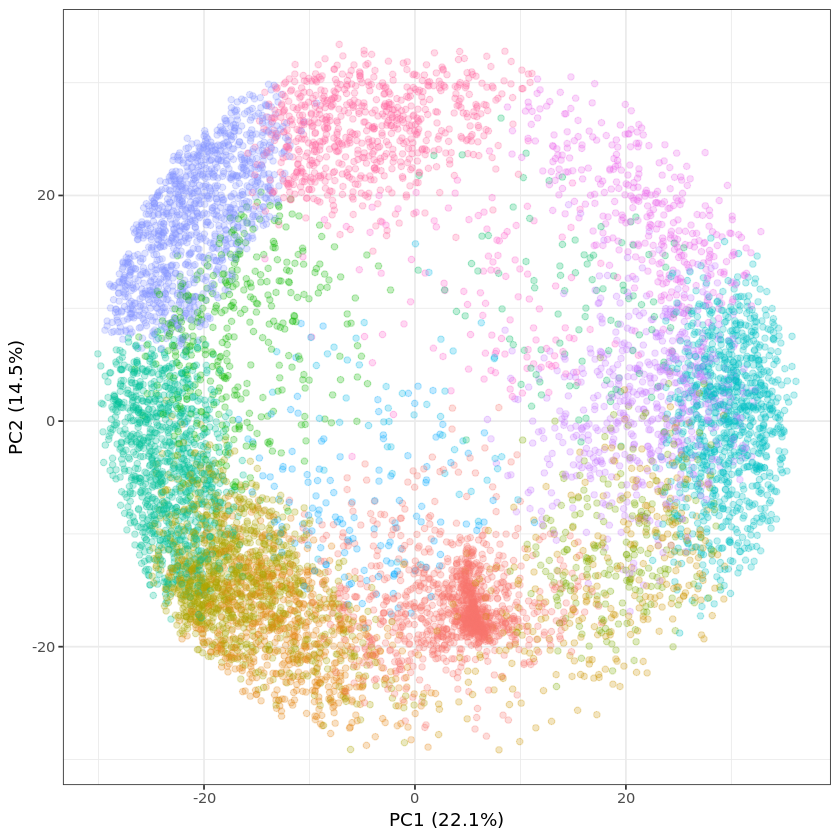

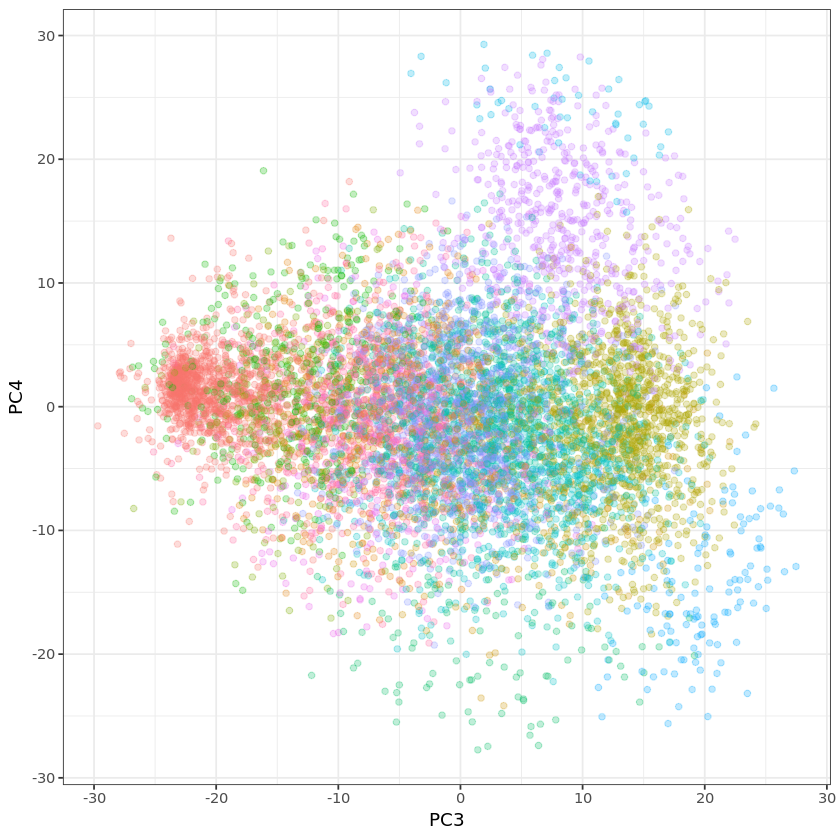

In [235]:
d <- x
d$node <- geneExpression_SOM$unit.classif
d$distances <- geneExpression_SOM$distances
d$gene <- rownames(d)

percentile_distance <-  quantile(d$distances, probs=seq(0, 1, 0.01))[['50%']]
percentile_distance <- as.double(percentile_distance)

for_plot <- d[d$distances < percentile_distance,]
dim(for_plot)

ggplot(for_plot, aes(x=PC1, y=PC2, color=factor(node))) + 
  geom_point(alpha=0.25) + 
  xlab("PC1 (22.1%)") + 
  ylab("PC2 (14.5%)") +
  theme_bw() + 
  theme(legend.position="none")

ggplot(for_plot, aes(x=PC3, y=PC4, color=factor(node))) + 
  geom_point(alpha=0.25) + 
  theme_bw() + 
  theme(legend.position="none")

In [236]:
#use for_plot for dist < median; use d for all
line_plot_mapping <- data.frame(gene=for_plot$gene, node=for_plot$node)
line_plot_wide <- as.data.frame(scale(vsdPT, center=T, scale=T))
line_plot_wide$sampleName <- rownames(line_plot_wide)
line_plot_wide <- merge(line_plot_wide, select(treatments, sampleName, Phenology, Tissue), by='sampleName')
line_plot_wide$PT <- paste(line_plot_wide$Phenology, line_plot_wide$Tissue, sep='_')
line_plot_wide$PT <- factor(line_plot_wide$PT, levels=c('Anthesis_Leaf', 'Veraison_Leaf', 'Harvest_Leaf', 
                                                        'Anthesis_Reproductive', 'Veraison_Reproductive', 'Harvest_Reproductive'),
                           labels = c('AL', 'VL', 'HL',
                                      'AR', 'VR', 'HR'))

line_plot_long <- line_plot_wide %>% tidyr::gather("gene", "ScaledExpr", Vitvi00g00444:Vitvi19g02388)
line_plot_long <- line_plot_long %>% group_by(gene, PT) %>% summarise(mScaledExpr=mean(ScaledExpr))
line_plot_long <- merge(line_plot_long, line_plot_mapping, by='gene')
line_plot_long$node <- as.factor(line_plot_long$node)
dim(line_plot_long)

[1] 53214     4

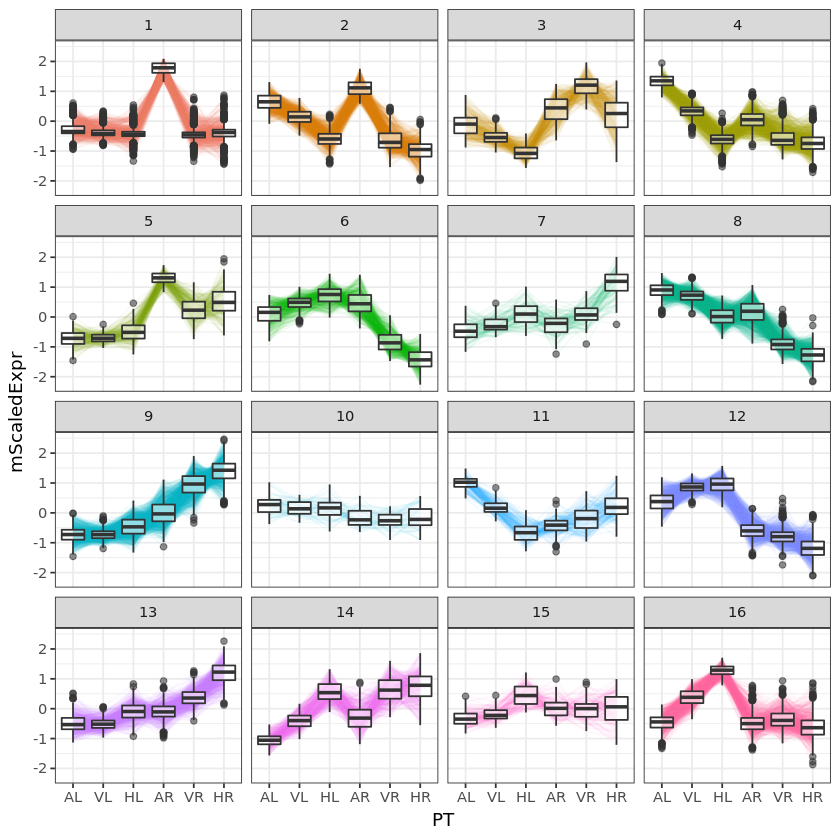

In [239]:
ggplot(line_plot_long) + 
  geom_line(aes(x=PT, y=mScaledExpr, group=gene, color=node, alpha=node), alpha=0.05, show.legend=FALSE) +
  geom_boxplot(aes(x=PT, y=mScaledExpr, alpha=0.0001), show.legend=FALSE) + 
  facet_wrap('node') +  
  theme_bw()

In [219]:
df <- t(vsd_counts_scaled)

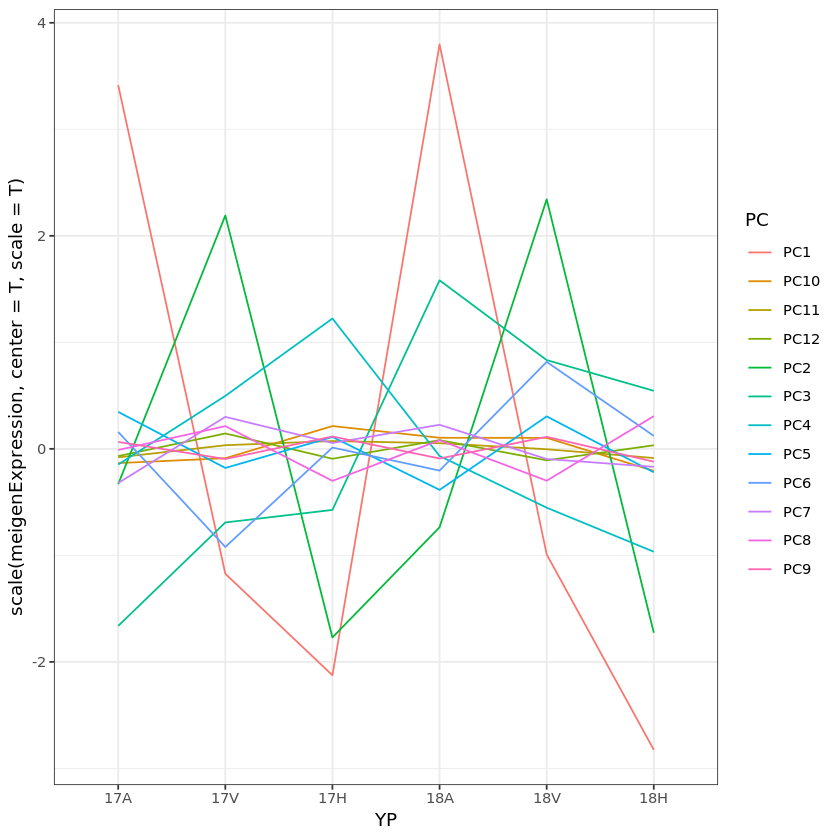

In [231]:
g <- line_plot_mapping$gene[line_plot_mapping$cluster=='10']
d <- as.data.frame(df[,g])
d$sampleName <- rownames(d)
d <- merge(d, select(treatments, sampleName, Year, Phenology), by='sampleName')
d$YP <- paste(d$Year, d$Phenology, sep='_')
d$YP <- factor(d$YP, levels=c('Y1_Anthesis', 'Y1_Veraison', 'Y1_Harvest', 
                              'Y2_Anthesis', 'Y2_Veraison', 'Y2_Harvest'),
               labels = c('17A', '17V', '17H',
               '18A', '18V', '18H'))

g1 <- colnames(d)[2]
g2 <- colnames(d)[length(colnames(d))-4]
pca <- prcomp(select(d, g1:g2))
x <- as.data.frame(pca$x)
x$YP <- d$YP

x <- x %>% tidyr::gather("PC", "eigenExpression", PC1:PC12)
x <- x %>% group_by(PC, YP) %>% summarise(meigenExpression=mean(eigenExpression))

ggplot(x, aes(x=YP, y=scale(meigenExpression, center=T, scale=T), group=PC, color=PC)) + 
  geom_line() + 
  theme_bw()

## Genes  for Rootstock

In [7]:
ls()

[1] "b_palette"          "genes_for_SOM"      "i_palette"         
 [4] "p_palette"          "r_palette"          "rs_palette"        
 [7] "t_palette"          "treatments"         "vsd_counts_varFilt"
[10] "y_palette"

In [5]:
#loads genes_for_SOM_YearPhenology
load('1719_genes_for_SOM_PVE_rootstock.Rdata')

vsdRS <- vsd_counts_varFilt[,genes_for_SOM]
vsd_counts_scaled <- as.data.frame(t(scale(vsdRS, center=T, scale=T)))

In [6]:
pca <- prcomp(vsd_counts_scaled)
x <- as.data.frame(pca$x)
#summary(pca)
dim(x)

pdf('1719_geneExpression_SOM_PCA_black.pdf', height=4.5, width=4.5)
ggplot(x, aes(x=PC1, y=PC2)) + 
  geom_point(alpha=0.45) + 
  xlab("PC1 (16.3%)") + 
  ylab("PC2 (10.3%)") + 
  theme_bw()
dev.off()

[1] 5495 1178

pdf 
  2

In [7]:
sqrt(dim(x)[1] / 10)

[1] 23.44142

In [8]:
set.seed(1992)

In [9]:
grid <- somgrid(9,9, 'hexagonal')
geneExpression_SOM <- som(as.matrix(vsd_counts_scaled), grid=grid, rlen=500, alpha=c(0.05, 0.01))

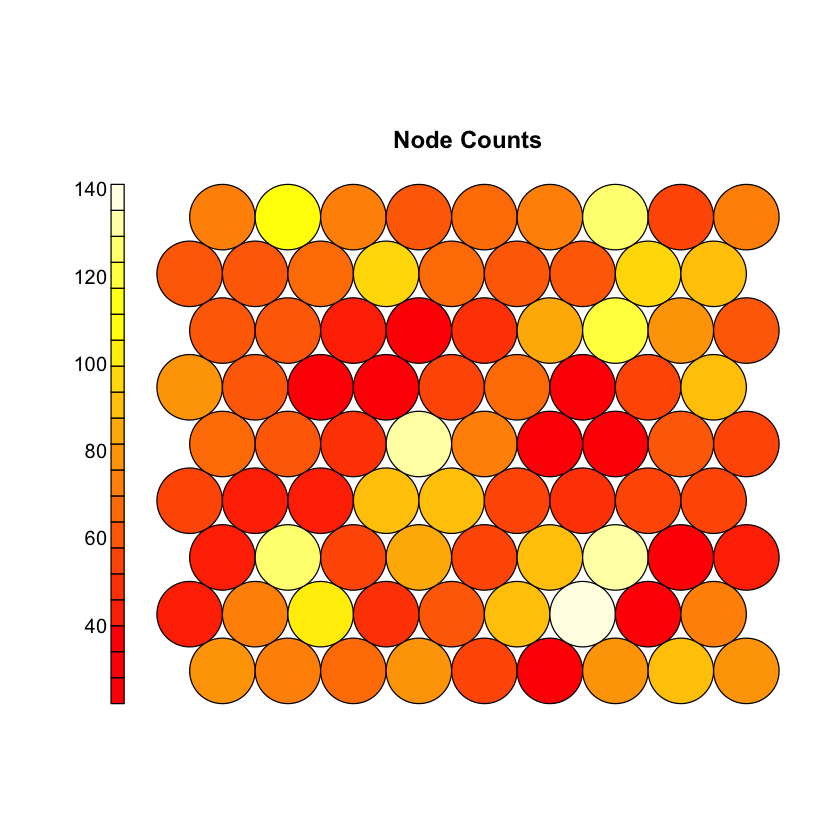

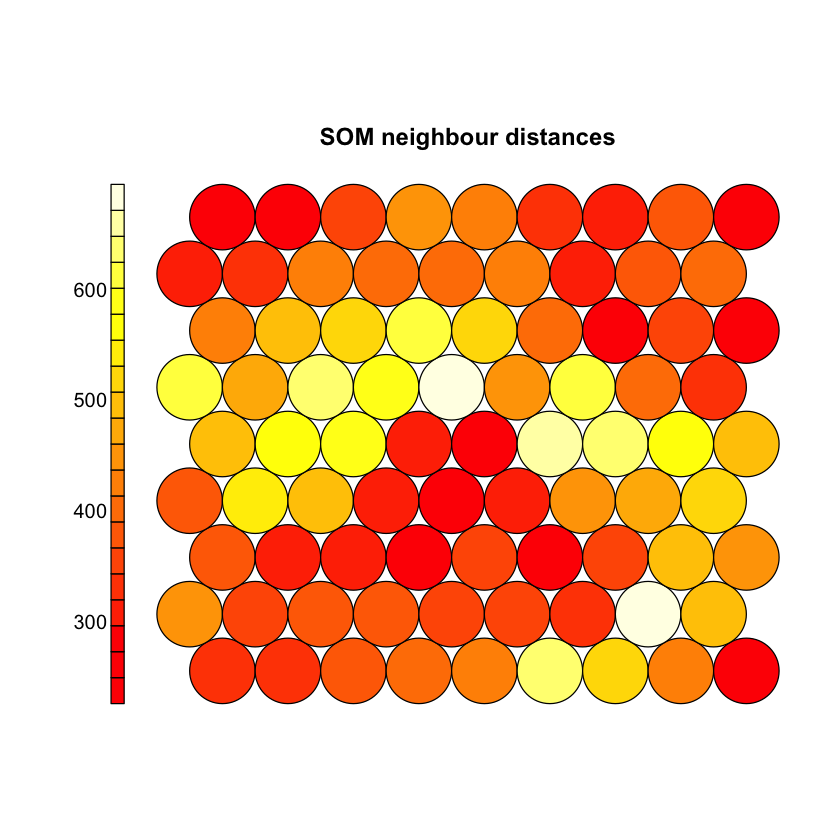

In [10]:
plot(geneExpression_SOM, type="count", main="Node Counts")
plot(geneExpression_SOM, type="dist.neighbours", main = "SOM neighbour distances")

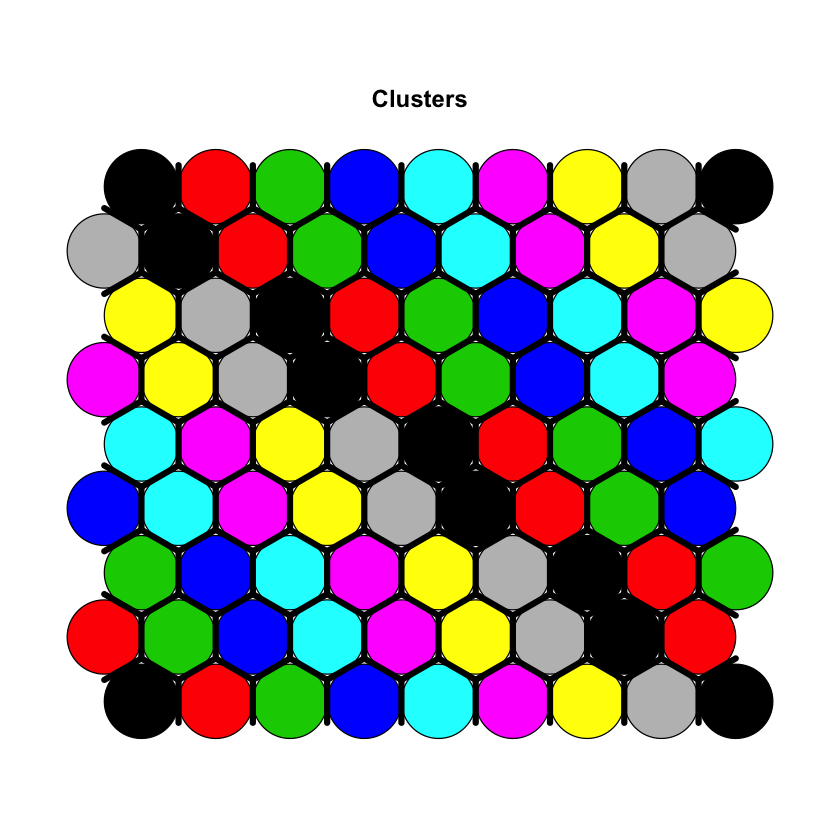

In [11]:
# stolen from https://iamciera.github.io/SOMexample/html/SOM_RNAseq_tutorial_part2a_SOM.html

# use hierarchical clustering to cluster the codebook vectors
som_cluster <- cutree(hclust(dist(geneExpression_SOM$codes[[1]])), 81)

# plot these results:
plot(geneExpression_SOM, type="mapping", bgcol = som_cluster, main = "Clusters", pch=NA) 
add.cluster.boundaries(geneExpression_SOM, som_cluster) 

In [12]:
# stolen from https://iamciera.github.io/SOMexample/html/SOM_RNAseq_tutorial_part2a_SOM.html

# Attach the hierchal cluster to the larger dataset data.val.
som_clusterKey <- data.frame(som_cluster)
som_clusterKey$unit.classif <- c(1:81)

d_rs <- cbind(x,geneExpression_SOM$unit.classif,geneExpression_SOM$distances)
head(x)
tail(x)

names(d_rs)[1179] <- "unit.classif"

d_rs$gene <- rownames(d_rs)
d_rs <- merge(d_rs, som_clusterKey, by.x = "unit.classif" )
head(d_rs)

PC1        PC2       PC3         PC4        PC5       PC6       
Vitvi00g00444  -5.834854 -3.016521 -17.0416988  -4.480282  3.454589 -10.833360
Vitvi00g00547  10.769204 -9.365696  -0.4462063   9.473031 -5.641343 -11.131594
Vitvi00g00675 -18.018778  2.202369  -7.4324827 -15.103724  3.947701  -7.071137
Vitvi00g00676 -20.300962 -1.001072  -9.6143523  -5.198010  9.104467   8.672916
Vitvi00g00711  -7.385197 -3.514907   1.0041375   4.671817 -6.108442   9.244493
Vitvi00g00789  -1.290674  1.032686  -5.5865418  -4.747320  0.137747  -8.292193
              PC7         PC8        PC9         PC10        ... PC1169     
Vitvi00g00444  0.13204499 -5.2542268 -2.16657830  0.01035456 ...  0.37014283
Vitvi00g00547  5.26833757  0.9926127 -8.06168870 -1.52045430 ...  0.31801797
Vitvi00g00675 -4.37950660 -1.8083472 -2.69987235 -4.68988849 ...  0.09624108
Vitvi00g00676  7.57758512 -3.0816603  4.19859849  9.23885124 ...  0.09975476
Vitvi00g00711 -0.06948912  6.9924569 -0.06437707 -0.65440542 ... -0.21665567
Vitvi00g00789  0.76828457 -2.4690389  0.66903337 -0.10707253 ...  0.21626211
              PC1170      PC1171       PC1172      PC1173      PC1174     
Vitvi00g00444  0.01530393 -0.386727603 -0.06209372  0.06696143  0.31499752
Vitvi00g00547  0.39871845 -0.368529581 -0.14938469 -0.07500612  0.09865094
Vitvi00g00675  0.12735138 -0.232138543  0.09099894 -0.65937032 -0.40032050
Vitvi00g00676 -0.02534911 -0.003264165  0.11181495  0.24172983  0.16650476
Vitvi00g00711 -0.09834845  0.201220884 -0.05793905  0.17307697  0.01126935
Vitvi00g00789  0.47368683  0.461859824 -0.19293837  0.04255928  0.78501649
              PC1175     PC1176      PC1177       PC1178       
Vitvi00g00444  0.3638901  0.32661945  0.123726946  1.776357e-15
Vitvi00g00547  0.3757934  0.15566526  0.224201760  6.661338e-16
Vitvi00g00675 -0.1413774  0.09033472 -0.203670931 -1.376677e-14
Vitvi00g00676 -0.1877709 -0.13253568  0.507448646  1.298961e-14
Vitvi00g00711 -0.7636179 -0.40206266 -0.006199081 -1.132427e-14
Vitvi00g00789  0.1676459 -0.17544253  0.039199815  1.049161e-14

PC1        PC2         PC3       PC4       PC5        PC6      
Vitvi19g02303   6.349823  -2.9706078 -3.928080 -5.669341  -3.506231  4.515430
Vitvi19g02308  -6.525312 -20.4513034  4.157326 -4.286098  -3.425136  8.862375
Vitvi19g02335  -5.521827   5.8972394 -9.237360 21.378331 -11.537234 -3.677280
Vitvi19g02337   6.015375  -0.3375927 -3.271213 -8.537547  -1.836755 -2.384368
Vitvi19g02338 -24.834861   6.6806152  5.693833  4.729280   7.034886 -4.886582
Vitvi19g02388 -17.956157   9.5741443 -5.542372  4.522456   2.207986 -1.871532
              PC7        PC8        PC9        PC10      ... PC1169    
Vitvi19g02303  5.3188583 -3.7561009  1.6376176 -4.772661 ... -0.1328997
Vitvi19g02308 -2.2550428 -6.5982002 -0.2974707  3.194942 ...  0.1029663
Vitvi19g02335 -0.2188589  0.8476935 -2.3495003 -1.849594 ... -0.1976500
Vitvi19g02337  0.5834553 -0.9954644  3.2017556 -2.069912 ... -0.1446261
Vitvi19g02338 -3.2803441 -1.0609106 -3.7524192 -6.193247 ...  0.2518306
Vitvi19g02388  3.0448717  3.3637457 -1.1157965  1.072591 ...  0.2836048
              PC1170      PC1171     PC1172       PC1173      PC1174      
Vitvi19g02303  0.11649520 -0.4319926 -0.010468917 -0.28848569  0.005730863
Vitvi19g02308  0.43099059  0.2199625  0.202140396 -0.02114541  0.376465507
Vitvi19g02335 -0.29008415 -0.4027101  0.474564296 -0.09606434  0.690895217
Vitvi19g02337  0.35133407  0.2060025  0.223685604  0.21845398  0.137723778
Vitvi19g02338 -0.27353034 -0.1214544 -0.219647262  0.39218721  0.242986104
Vitvi19g02388  0.03574466 -0.2883055  0.006172978 -0.03221707 -0.025500293
              PC1175      PC1176      PC1177      PC1178       
Vitvi19g02303 -0.21780969  0.08579770  0.01483509 -1.998401e-14
Vitvi19g02308 -0.21168895 -0.49051901  0.05280876 -3.774758e-15
Vitvi19g02335  0.05091347  0.08004894  0.19350698 -1.199041e-14
Vitvi19g02337  0.33607265 -0.83700076  0.14083752 -1.065814e-14
Vitvi19g02338 -0.09617509  0.08705983  0.15572605  9.103829e-15
Vitvi19g02388  0.31649744  0.38174009 -0.29572002 -1.110223e-15

unit.classif PC1      PC2       PC3      PC4       PC5       PC6       
1 1            31.88963 -4.212317 4.686646 -3.602660 -3.914388 -4.9889755
2 1            23.83823 -8.691248 1.569269 13.015605  2.626191 -1.5989026
3 1            28.07409  5.143968 7.436682 10.302013 10.272246 -8.8815881
4 1            27.74540  1.137401 8.916487 -1.192840  0.847755 -3.1244499
5 1            28.56578  1.090038 4.487227 -4.463052 15.384977  0.2125913
6 1            22.54333 -7.117665 6.612178  7.998698 11.577201 -6.2135662
  PC7       PC8        PC9        ... PC1172       PC1173      PC1174     
1 -5.835389 -2.5816100 -0.7081652 ...  0.040640000  0.16470495 -0.01042267
2 -4.719618 -8.8857227 -2.6343203 ... -0.341235755 -0.10899766 -0.19986146
3  2.484983  1.8153283  1.3245659 ... -0.358584938  0.13665412 -0.01661779
4 -8.190017  6.0923513 10.0635037 ... -0.144926231 -0.03142811  0.08109670
5 -4.176556 -6.5751963  3.5302904 ...  0.076761358 -0.23820086 -0.01469465
6  2.809451 -0.4071952 -1.4473935 ... -0.009337516  0.00465524 -0.18052314
  PC1175     PC1176     PC1177     PC1178        geneExpression_SOM$distances
1  0.1666787 0.06519523  0.1253354  2.220446e-16 259.7217                    
2 -0.1808962 0.10976278  0.2352484  1.543210e-14 609.6996                    
3 -0.2261627 0.02126551 -0.1557544  1.665335e-15 426.2356                    
4  0.2640131 0.25656483 -0.3582833  4.440892e-15 475.5321                    
5 -0.1031600 0.22406667 -0.1882798 -2.664535e-15 418.9061                    
6 -0.2719402 0.07768913  0.2620293  5.773160e-15 627.5620                    
  gene          som_cluster
1 Vitvi05g01118 1          
2 Vitvi06g00632 1          
3 Vitvi04g01691 1          
4 Vitvi07g00534 1          
5 Vitvi11g01429 1          
6 Vitvi11g01705 1

In [36]:
pdf('1719_geneExpression_SOM_PCA_fullColor.pdf', height=4.5, width=4.5)
ggplot(d_rs, aes(x=PC1, y=PC2, color=factor(som_cluster))) + 
  geom_point(alpha=0.45) + 
  xlab("PC1 (16.3%)") + 
  ylab("PC2 (10.3%)") + 
  theme_bw() + 
  theme(legend.position='none')
dev.off()

pdf 
  2

In [34]:
# Dan (I think) only included genes whose distance to their node was < the median of all distances. 

percentile_distance <-  quantile(d_rs$`geneExpression_SOM$distances`, probs=seq(0, 1, 0.01))[['50%']]
percentile_distance <- as.double(percentile_distance)

for_plot <- d_rs[d_rs$`geneExpression_SOM$distances` < percentile_distance,]
dim(for_plot)

pdf('1719_geneExpression_SOM_PCA_medDistFiltColor.pdf', height=4.5, width=4.5)
ggplot(for_plot, aes(x=PC1, y=PC2, color=factor(som_cluster))) + 
  geom_point(alpha=0.45) + 
  xlab("PC1 (16.3%)") + 
  ylab("PC2 (10.3%)") + 
  #scale_color_manual(values=viridisLite::viridis(81)) +
  theme_bw() + 
  theme(legend.position = 'none')
dev.off()

[1] 2747 1182

pdf 
  2

[1] 10984     4

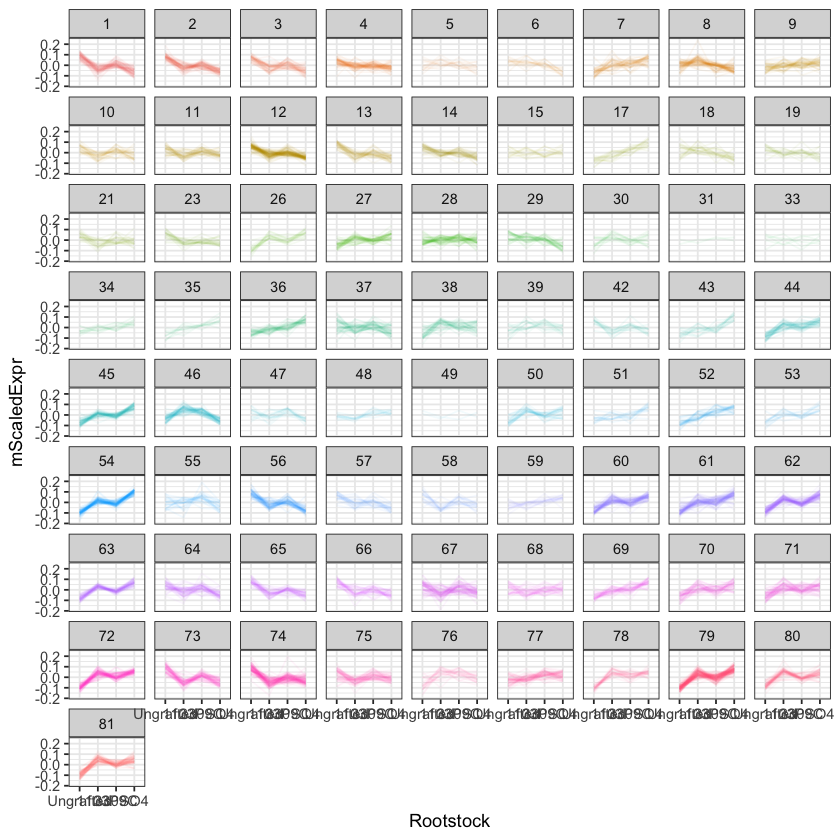

In [32]:
#use for_plot for dist < median; use d for all
line_plot_mapping <- data.frame(gene=for_plot$gene, cluster=for_plot$som_cluster)
line_plot_wide <- as.data.frame(scale(vsdRS, center=T, scale=T))
line_plot_wide$sampleName <- rownames(line_plot_wide)
line_plot_wide <- merge(line_plot_wide, select(treatments, sampleName, Rootstock), by='sampleName')

line_plot_long <- line_plot_wide %>% tidyr::gather("gene", "ScaledExpr", Vitvi00g00444:Vitvi19g02338)
line_plot_long <- line_plot_long %>% group_by(gene, Rootstock) %>% summarise(mScaledExpr=mean(ScaledExpr))
line_plot_long <- merge(line_plot_long, line_plot_mapping, by='gene')
line_plot_long$cluster <- as.factor(line_plot_long$cluster)
line_plot_long <- line_plot_long[line_plot_long$gene != 'Vitvi04g01352',]

dim(line_plot_long)

ggplot(line_plot_long, aes(x=Rootstock, y=mScaledExpr, group=gene, color=cluster, alpha=cluster)) + 
  geom_line(alpha=0.05, show.legend=FALSE) +
  #scale_color_manual(values=viridisLite::viridis(81)) +
  facet_wrap('cluster') +  
  theme_bw()

In [16]:
se <- function(x){
    se <- sd(x) / sqrt(length(x))
    return(se)
}

line_plot_long_m_se <- line_plot_long %>% 
  group_by(cluster,Rootstock) %>%
  summarise(m=mean(mScaledExpr), sd=sd(mScaledExpr))

pdf('1719_geneExpression_SOM_clusters_9x9.pdf', height=15, width=15)
ggplot(line_plot_long) + 
  geom_line(aes(x=Rootstock, y=mScaledExpr, group=gene, color=cluster, alpha=cluster), alpha=0.07, show.legend=FALSE) +
  geom_linerange(aes(x=Rootstock, ymin=m-sd, ymax=m+sd), color='grey60', line_plot_long_m_se, lwd=1.5) +
  geom_point(aes(x=Rootstock, y=m), size=2, shape=21, fill='grey60', stroke=1, data=line_plot_long_m_se) + 
  facet_wrap('cluster') +  
  theme_bw()
dev.off()

pdf 
  2

In [17]:
clusters <- sort(unique(line_plot_long$cluster))
length(clusters)

[1] 73

In [53]:
aa <- lm(mScaledExpr~Rootstock, data=filter(line_plot_long, cluster==54)) %>%
  car::Anova(type=2) %>%
  .$Sum

aa / sum(aa)

[1] 0.9209679 0.0790321

In [68]:
lmfun <- function(cluster_id, data){
    if (!(cluster_id %in% unique(data$cluster))) {
        print(str_interp('Cluster ${cluster_id} has no genes'))
        return (1)
    } else {
        d <- data %>% filter(cluster == cluster_id)
        if (length(unique(d$gene)) < 16){
            print(str_interp('Cluster ${cluster_id} has < 16 genes'))
            return(1)
        } else {
            rootstock_pvalue <- lm(mScaledExpr~Rootstock, data=d) %>%
              car::Anova(., type=2) %>%
              .[['Pr(>F)']] %>%
             .[1] 
            return(rootstock_pvalue)
        }
    }
}

xxx <- lapply(X=1:81, FUN=lmfun, data=line_plot_long)
xxx <- unlist(xxx)
length(xxx[xxx < 1e-05])

[1] "Cluster 5 has < 16 genes"
[1] "Cluster 6 has < 16 genes"
[1] "Cluster 15 has < 16 genes"
[1] "Cluster 16 has no genes"
[1] "Cluster 20 has no genes"
[1] "Cluster 22 has no genes"
[1] "Cluster 24 has no genes"
[1] "Cluster 25 has no genes"
[1] "Cluster 30 has < 16 genes"
[1] "Cluster 31 has < 16 genes"
[1] "Cluster 32 has no genes"
[1] "Cluster 33 has < 16 genes"
[1] "Cluster 34 has < 16 genes"
[1] "Cluster 35 has < 16 genes"
[1] "Cluster 39 has < 16 genes"
[1] "Cluster 40 has no genes"
[1] "Cluster 41 has no genes"
[1] "Cluster 42 has < 16 genes"
[1] "Cluster 43 has < 16 genes"
[1] "Cluster 47 has < 16 genes"
[1] "Cluster 48 has < 16 genes"
[1] "Cluster 49 has < 16 genes"
[1] "Cluster 51 has < 16 genes"
[1] "Cluster 53 has < 16 genes"
[1] "Cluster 59 has < 16 genes"


[1] 53

In [76]:
clusters_to_enrich <- 
  data.frame(cluster=1:81, pval=xxx, signif=xxx<1e-05) %>%
  filter(signif==TRUE) %>%
  .[['cluster']]

line_plot_long %>%
  filter(cluster %in% clusters_to_enrich) %>%
  select(gene, cluster) %>%
  unique() %>%
  write.csv(file='1719_geneExpression_SOM_clusters_9x9.csv')

line_plot_long_filt <- line_plot_long %>%
  filter(cluster %in% clusters_to_enrich)

table(line_plot_long_filt$cluster)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19  21  23 
256 240 164 244   0   0 140 220 164 108 148 372 140 148   0  64  84   0  88  88 
 26  27  28  29  30  31  33  34  35  36  37  38  39  42  43  44  45  46  47  48 
 64 152   0 112   0   0   0   0   0 136 168 132   0   0   0 152 208 204   0   0 
 49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68 
  0  92   0 108   0 312  88 192  84  68   0 288 308 300 228 212 160 140 268   0 
 69  70  71  72  73  74  75  76  77  78  79  80  81 
156 164 200 328 236 372 212  88 212 116 480 188 244 

In [70]:
for_plot_filt <- for_plot %>%
  filter(som_cluster %in% clusters_to_enrich)

pdf('1719_geneExpression_SOM_PCA_medDistFiltColor_filt.pdf', height=4.5, width=4.5)
ggplot(for_plot_filt, aes(x=PC1, y=PC2, color=factor(som_cluster))) + 
  geom_point(alpha=0.45) + 
  xlab("PC1 (16.3%)") + 
  ylab("PC2 (10.3%)") + 
  theme_bw() + 
  theme(legend.position = 'none')
dev.off()

pdf 
  2

In [71]:
length(unique(line_plot_long_filt$cluster))

[1] 53

In [72]:
line_plot_long_m_se_filt <- line_plot_long_filt %>% 
  group_by(cluster,Rootstock) %>%
  summarise(m=mean(mScaledExpr), sd=sd(mScaledExpr))

pdf('1719_geneExpression_SOM_clusters_9x9_filt.pdf', height=15, width=15)
ggplot(line_plot_long_filt) + 
  geom_line(aes(x=Rootstock, y=mScaledExpr, group=gene, color=cluster, alpha=cluster), alpha=0.07, show.legend=FALSE) +
  geom_linerange(aes(x=Rootstock, ymin=m-sd, ymax=m+sd), color='grey60', line_plot_long_m_se_filt, lwd=1.5) +
  geom_point(aes(x=Rootstock, y=m), size=2, shape=21, fill='grey60', stroke=1, data=line_plot_long_m_se_filt) + 
  facet_wrap('cluster') +  
  theme_bw()
dev.off()

pdf 
  2

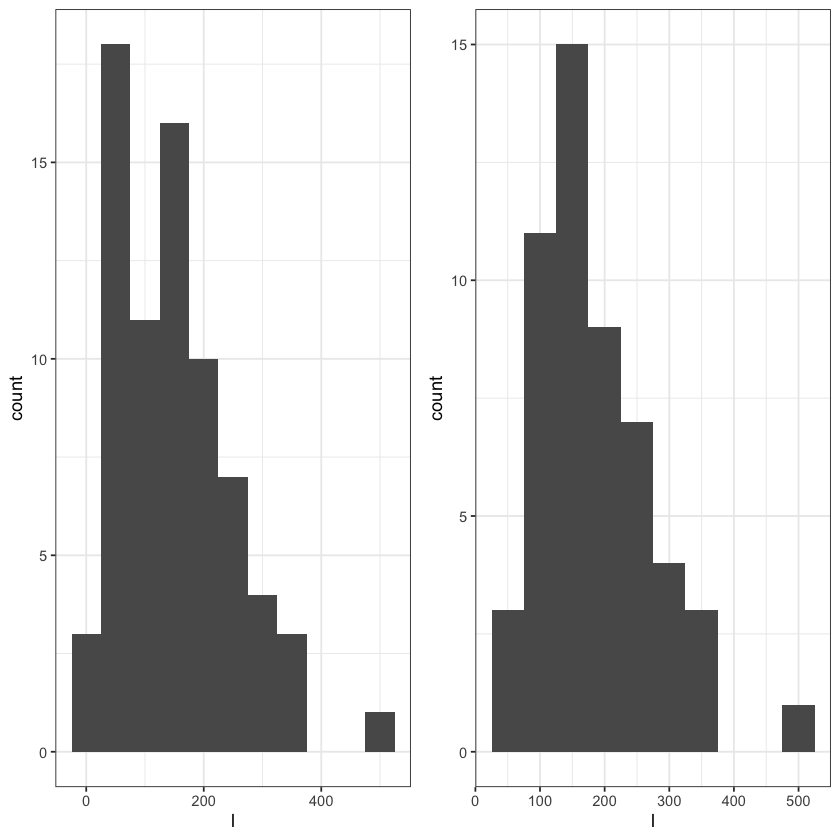

In [73]:
aa <- line_plot_long %>% 
  group_by(cluster) %>% 
  summarise(l=length(mScaledExpr)) %>% 
  ggplot(., aes(x=l)) + 
    geom_histogram(binwidth=50) + 
    theme_bw()

bb <- line_plot_long_filt %>% 
  group_by(cluster) %>% 
  summarise(l=length(mScaledExpr)) %>% 
  ggplot(., aes(x=l)) + 
    geom_histogram(binwidth=50) + 
    theme_bw()

ggpubr::ggarrange(aa, bb, ncol=2)

In [62]:
pvefun <- function(cluster_id, data){
    if (!(cluster_id %in% unique(data$cluster))) {
        print(str_interp('Cluster ${cluster_id} has no genes'))
        return (0)
    } else {
        d <- data %>% filter(cluster == cluster_id)
        if (length(unique(d$gene)) < 16){
            print(str_interp('Cluster ${cluster_id} has < 16 genes'))
            return(0)
        } else {
            rootstock_pve <- lm(mScaledExpr~Rootstock, data=d) %>%
              car::Anova(., type=2) %>%
              .$Sum
            return((rootstock_pve/sum(rootstock_pve))[1])
        }
    }
}

xxx <- lapply(X=1:81, FUN=pvefun, data=line_plot_long)
yyy <- lapply(X=1:81, FUN=lmfun, data=line_plot_long)
xdf <- data.frame(cluster=1:81, pve=unlist(xxx), pval=unlist(yyy), isSig=unlist(yyy)<1e-05)
xdf %>%
  group_by(isSig) %>%
  summarise(min=min(pve), max=max(pve), m=mean(pve))

[1] "Cluster 5 has < 16 genes"
[1] "Cluster 6 has < 16 genes"
[1] "Cluster 15 has < 16 genes"
[1] "Cluster 16 has no genes"
[1] "Cluster 20 has no genes"
[1] "Cluster 22 has no genes"
[1] "Cluster 24 has no genes"
[1] "Cluster 25 has no genes"
[1] "Cluster 30 has < 16 genes"
[1] "Cluster 31 has < 16 genes"
[1] "Cluster 32 has no genes"
[1] "Cluster 33 has < 16 genes"
[1] "Cluster 34 has < 16 genes"
[1] "Cluster 35 has < 16 genes"
[1] "Cluster 39 has < 16 genes"
[1] "Cluster 40 has no genes"
[1] "Cluster 41 has no genes"
[1] "Cluster 42 has < 16 genes"
[1] "Cluster 43 has < 16 genes"
[1] "Cluster 47 has < 16 genes"
[1] "Cluster 48 has < 16 genes"
[1] "Cluster 49 has < 16 genes"
[1] "Cluster 51 has < 16 genes"
[1] "Cluster 53 has < 16 genes"
[1] "Cluster 59 has < 16 genes"
[1] "Cluster 5 has < 16 genes"
[1] "Cluster 6 has < 16 genes"
[1] "Cluster 15 has < 16 genes"
[1] "Cluster 16 has no genes"
[1] "Cluster 20 has no genes"
[1] "Cluster 22 has no genes"
[1] "Cluster 24 has no genes"
[1] 

isSig min      max       m         
1 FALSE 0.000000 0.2412070 0.01497456
2  TRUE 0.163694 0.9209679 0.60206659

In [67]:
write.csv(xdf, file='1719_geneExpression_SOM_clusters_lmResults.csv')

In [94]:
lmfun(cluster_id = 27, data=line_plot_long)



[1] 1.22149e-15

In [59]:
line_plot_long %>% 
  select(gene, cluster) %>% 
  unique() %>%
  write.csv(file='1719_geneExpression_SOM_clusters.csv')

[1] 4121 1181

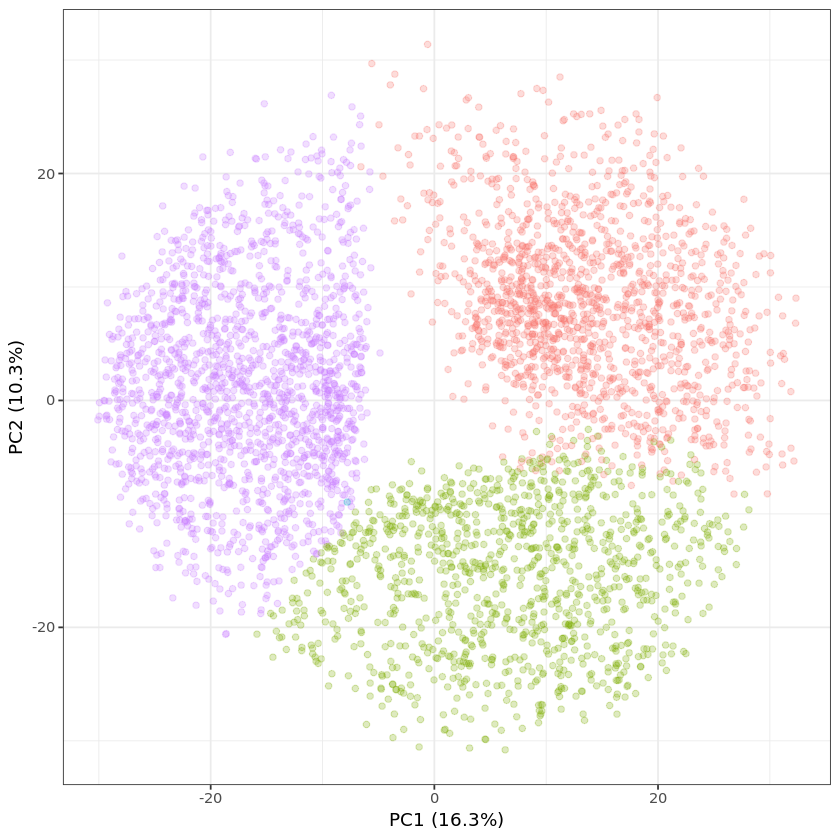

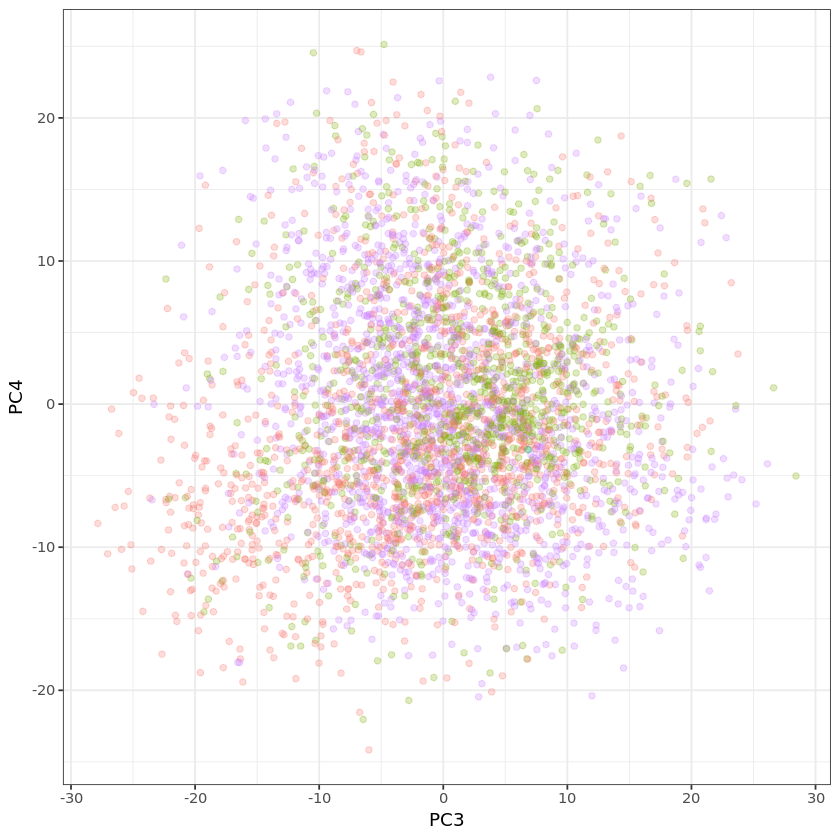

In [210]:
d <- x
d$node <- geneExpression_SOM$unit.classif
d$distances <- geneExpression_SOM$distances
d$gene <- rownames(d)

percentile_distance <-  quantile(d$distances, probs=seq(0, 1, 0.01))[['75%']]
percentile_distance <- as.double(percentile_distance)

for_plot <- d[d$distances < percentile_distance,]
dim(for_plot)

ggplot(for_plot, aes(x=PC1, y=PC2, color=factor(node))) + 
  geom_point(alpha=0.25) + 
  xlab("PC1 (16.3%)") + 
  ylab("PC2 (10.3%)") + 
  theme_bw() + 
  theme(legend.position="none")

ggplot(for_plot, aes(x=PC3, y=PC4, color=factor(node))) + 
  geom_point(alpha=0.25) + 
  theme_bw() + 
  theme(legend.position="none")

In [211]:
#use for_plot for dist < median; use d for all
line_plot_mapping <- data.frame(gene=for_plot$gene, node=for_plot$node)
line_plot_wide <- as.data.frame(scale(vsdRS, center=T, scale=T))
line_plot_wide$sampleName <- rownames(line_plot_wide)
line_plot_wide <- merge(line_plot_wide, select(treatments, sampleName, Rootstock), by='sampleName')

line_plot_long <- line_plot_wide %>% tidyr::gather("gene", "ScaledExpr", Vitvi00g00444:Vitvi19g02388)
line_plot_long <- line_plot_long %>% group_by(gene, Rootstock) %>% summarise(mScaledExpr=mean(ScaledExpr))
line_plot_long <- merge(line_plot_long, line_plot_mapping, by='gene')
line_plot_long$node <- as.factor(line_plot_long$node)
dim(line_plot_long)

[1] 16484     4

In [219]:
colnames(line_plot_long)

[1] "gene"        "Rootstock"   "mScaledExpr" "node"

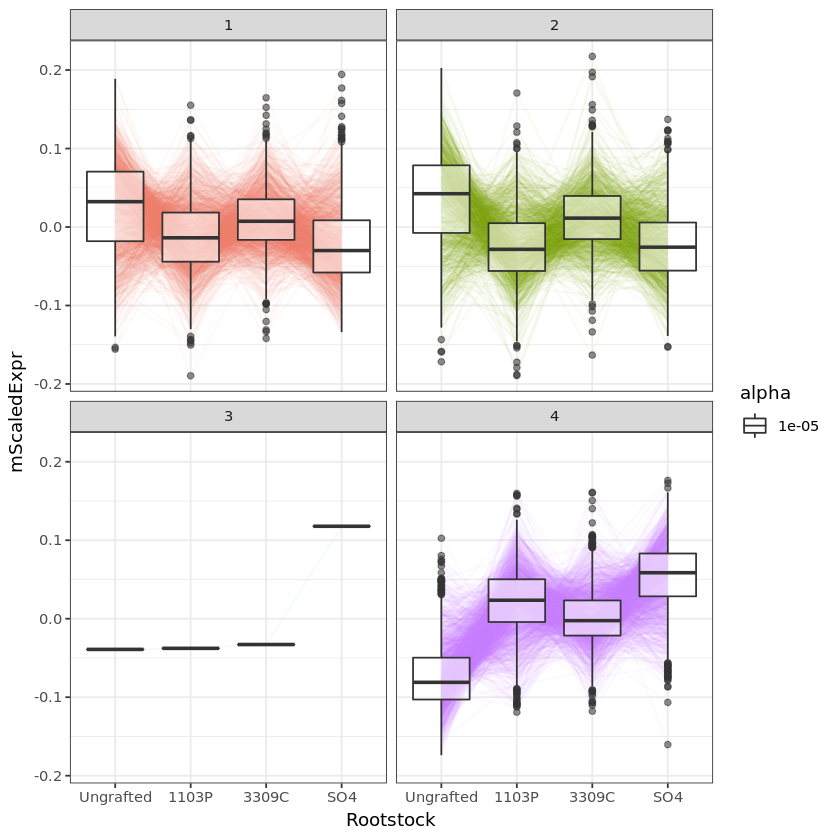

In [224]:
ggplot(line_plot_long) + 
  geom_line(aes(x=Rootstock, y=mScaledExpr, group=gene, color=node), alpha=0.05, show.legend=FALSE) + 
  geom_boxplot(aes(x=Rootstock, y=mScaledExpr, alpha=0.00001)) + 
  facet_wrap('node') +  
  theme_bw()


## Rootstock Comparisons - no SOMs

In [7]:
load('1718_geneExpression_reproctive_whichPostHocs.Rdata')

In [12]:
lm_out <- read.csv('1718_Reproductive_geneExpression_lm_out.csv', header=T)
lm_out_padj <- lm_out %>% select(Irrigation_p:`Year.Phenology.Rootstock.Block_p`) %>% apply(MARGIN=2, FUN=p.adjust, method='fdr') %>% as.data.frame()

count_sigGenes <- function(p_vec, p_cutoff){
    check <- rep(FALSE, length(p_vec))
    check[p_vec < p_cutoff] <- TRUE
    return(sum(check))
}

extract_sigGenes <- function(p_vec, p_cutoff){
    check <- rep(FALSE, length(p_vec))
    check[p_vec < p_cutoff] <- TRUE
    return(lm_out$gene[check])
}

#apply(X=glm_out_padj, MARGIN=2, FUN=count_sigGenes, p_cutoff=0.05)
sigGenesCounts <- apply(X=lm_out_padj, MARGIN=2, FUN=count_sigGenes, p_cutoff=0.05)
sigGenesCounts

sigGenes <- apply(X=lm_out_padj, MARGIN=2, FUN=extract_sigGenes, p_cutoff=0.05)

X.Intercept._ss Irrigation_ss Year_ss   Phenology_ss Rootstock_ss Block_ss 
1 1.030240e-03    2.08145328     2.213779 64.1120233   1.5301986    2.1398846
2 1.111120e-03    2.67784926    37.052260  0.2100123   0.5290252    0.2036531
3 1.232738e-04    2.77562485    28.972327 54.5143222   7.7438339    1.7224075
4 6.181846e-04    1.03037983     5.211747 58.1023042   1.2084240    4.1721894
5 2.666847e-03    0.09890447    54.282315 86.8444133   1.2402184    1.9619289
6 1.519785e-05    0.28363198    25.326171 82.5158543   3.2060626    2.9797412
  Year.Phenology_ss Year.Rootstock_ss Phenology.Rootstock_ss Year.Block_ss ⋯
1  9.743244         3.75843675         3.558576              1.9777138     ⋯
2  6.015755         1.73046319        11.631752              1.0012744     ⋯
3  5.498740         0.51337511         2.063239              0.1050559     ⋯
4 43.764921         0.24727064         2.394029              0.5247970     ⋯
5 29.290349         0.17898732         2.977778              4.5148671     ⋯
6 22.266464         0.08862068         4.023619              2.9703678     ⋯
  Year.Block_p Phenology.Block_p Rootstock.Block_p Year.Phenology.Rootstock_p
1 0.30940570   0.6380554         0.70767852        0.9741786                 
2 0.57639976   0.7544552         0.25574434        0.2210397                 
3 0.93528636   0.1167923         0.08481922        0.5044991                 
4 0.70746379   0.2589618         0.13469178        0.5599203                 
5 0.02191049   0.2246270         0.78253161        0.5914435                 
6 0.11904395   0.3893214         0.24755032        0.6330426                 
  Year.Phenology.Block_p Year.Rootstock.Block_p Phenology.Rootstock.Block_p
1 0.713046350            0.8671448              0.1779698                  
2 0.856938606            0.2920896              0.2781935                  
3 0.065313086            0.2899803              0.9077025                  
4 0.440988843            0.3369849              0.2346367                  
5 0.009885865            0.3892017              0.1817066                  
6 0.059514156            0.6782118              0.1280014                  
  Year.Phenology.Rootstock.Block_p gene          isAliased
1 0.2777024                        Vitvi00g00444 no       
2 0.8371561                        Vitvi00g00447 no       
3 0.6694926                        Vitvi00g00547 no       
4 0.6714184                        Vitvi00g00610 no       
5 0.4060475                        Vitvi00g00612 no       
6 0.7609895                        Vitvi00g00614 no

Irrigation_p                           Year_p 
                               0                            14880 
                     Phenology_p                      Rootstock_p 
                           19635                               17 
                         Block_p                 Year.Phenology_p 
                            6312                            15246 
                Year.Rootstock_p            Phenology.Rootstock_p 
                               3                                9 
                    Year.Block_p                Phenology.Block_p 
                             835                             5572 
               Rootstock.Block_p       Year.Phenology.Rootstock_p 
                              13                               14 
          Year.Phenology.Block_p           Year.Rootstock.Block_p 
                            3353                                4 
     Phenology.Rootstock.Block_p Year.Phenology.Rootstock.Block_p 
                              16                               52

In [78]:
x <- as.character(unlist(sigGenes$Rootstock_p))
x

[1] "Vitvi00g02237" "Vitvi01g00513" "Vitvi01g00914" "Vitvi01g02061"
 [5] "Vitvi04g01352" "Vitvi05g00576" "Vitvi05g01835" "Vitvi06g00292"
 [9] "Vitvi06g01036" "Vitvi07g01502" "Vitvi09g01551" "Vitvi10g01368"
[13] "Vitvi10g01764" "Vitvi12g00327" "Vitvi14g00168" "Vitvi18g00861"
[17] "Vitvi19g01580"

In [91]:
to_plot <- vsd_counts_varFilt %>% select(x)
to_plot_scale <- as.data.frame(scale(to_plot, center=T, scale=T))
to_plot_scale$sampleName <- rownames(to_plot)
to_plot_scale <- merge(to_plot_scale, select(treatments, sampleName, Rootstock))
head(to_plot_scale)

to_plot_scale_long <- to_plot_scale %>% tidyr::gather("gene", "ScaledExpr", x[1]:x[length(x)])
#to_plot_scale_long <- to_plot_scale_long %>% group_by(gene, Rootstock) %>% summarise(mScaledExpr=mean(ScaledExpr))
head(to_plot_scale_long)

sampleName Vitvi00g02237 Vitvi01g00513 Vitvi01g00914 Vitvi01g02061
1 A1Y1_001_R 0.8430392      1.1289481    -0.08411593   -1.749662    
2 A1Y1_002_R 0.4426392     -0.3341901    -0.58083185   -1.143013    
3 A1Y1_003_R 0.1576762      1.3368657    -1.08566551   -1.121511    
4 A1Y1_004_R 1.2447867      0.1880758    -0.77788710   -1.363283    
5 A1Y1_005_R 1.5711696      1.1085122    -0.73771189   -1.238648    
6 A1Y1_006_R 1.6290415      0.6795787    -1.13670550   -1.211388    
  Vitvi04g01352 Vitvi05g00576 Vitvi05g01835 Vitvi06g00292 Vitvi06g01036
1 -0.40205380   0.1980277     1.840720      1.1018403     -1.0391937   
2  0.04526518   1.0813795     2.554507      1.3510022      2.0576038   
3 -0.13552426   0.3979436     2.488083      1.5567783      1.8064782   
4 -0.05795897   1.1041049     2.069298      1.8287346      0.6839511   
5 -0.53060117   1.0022956     1.409244      0.6466927      0.7972876   
6  0.03600521   1.0235952     1.193472      0.6497278     -0.2469773   
  Vitvi07g01502 Vitvi09g01551 Vitvi10g01368 Vitvi10g01764 Vitvi12g00327
1 -1.21286951   -0.7704027     0.24512523    0.6660362    1.161559     
2  0.18655519   -0.7704027    -0.56194178   -0.1506008    1.310855     
3 -0.09829537   -0.7704027     0.38849851   -1.2333410    1.588230     
4 -0.19680110   -0.7704027     1.35990323    0.9762537    1.658095     
5 -0.06945990   -0.7704027     0.69497838    1.3614408    0.914840     
6 -0.92980938   -0.7704027     0.09329946    1.5464147    1.207096     
  Vitvi14g00168 Vitvi18g00861 Vitvi19g01580 Rootstock
1 0.9188884     -0.3182272    -1.8758354    1103P    
2 2.2304726     -0.3182272    -1.8758354    1103P    
3 1.2573116      2.4127782    -0.6909891    3309C    
4 0.5964188      3.0610140     0.1817803    3309C    
5 0.9893033     -0.3182272    -0.8274219    SO4      
6 0.7812250     -0.3182272     0.3496971    SO4

sampleName Rootstock gene          ScaledExpr
1 A1Y1_001_R 1103P     Vitvi00g02237 0.8430392 
2 A1Y1_002_R 1103P     Vitvi00g02237 0.4426392 
3 A1Y1_003_R 3309C     Vitvi00g02237 0.1576762 
4 A1Y1_004_R 3309C     Vitvi00g02237 1.2447867 
5 A1Y1_005_R SO4       Vitvi00g02237 1.5711696 
6 A1Y1_006_R SO4       Vitvi00g02237 1.6290415

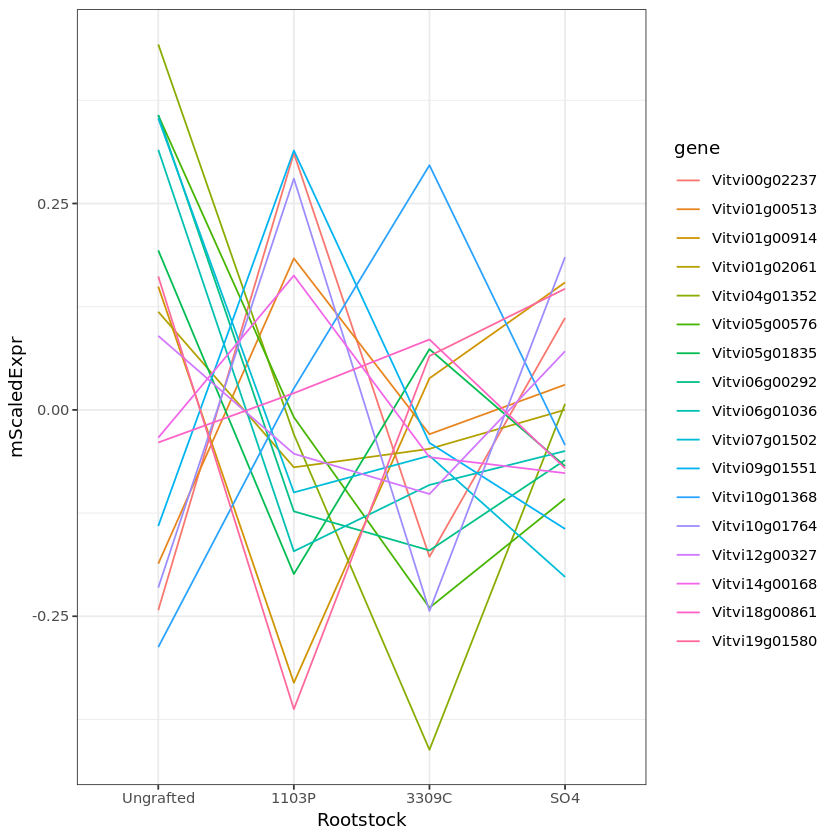

In [90]:
# ggplot(to_plot_scale_long, aes(x=Rootstock, y=mScaledExpr, color=gene, group=gene)) + 
#   geom_line() + 
#   theme_bw()

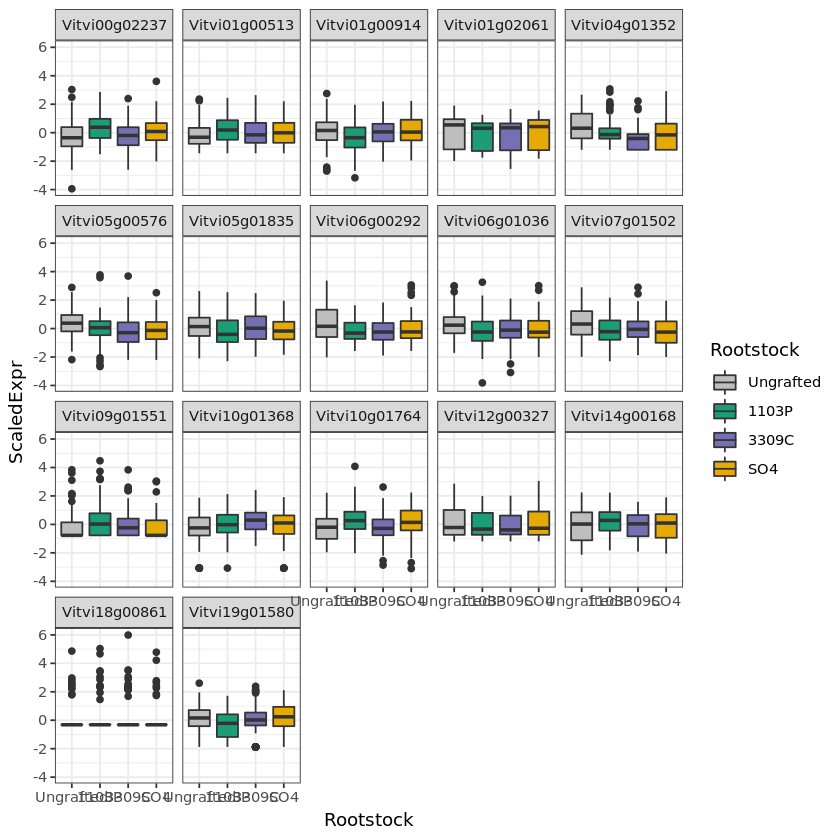

In [92]:
ggplot(to_plot_scale_long, aes(x=Rootstock, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_wrap('gene') + 
  theme_bw()

[1] 5512    5

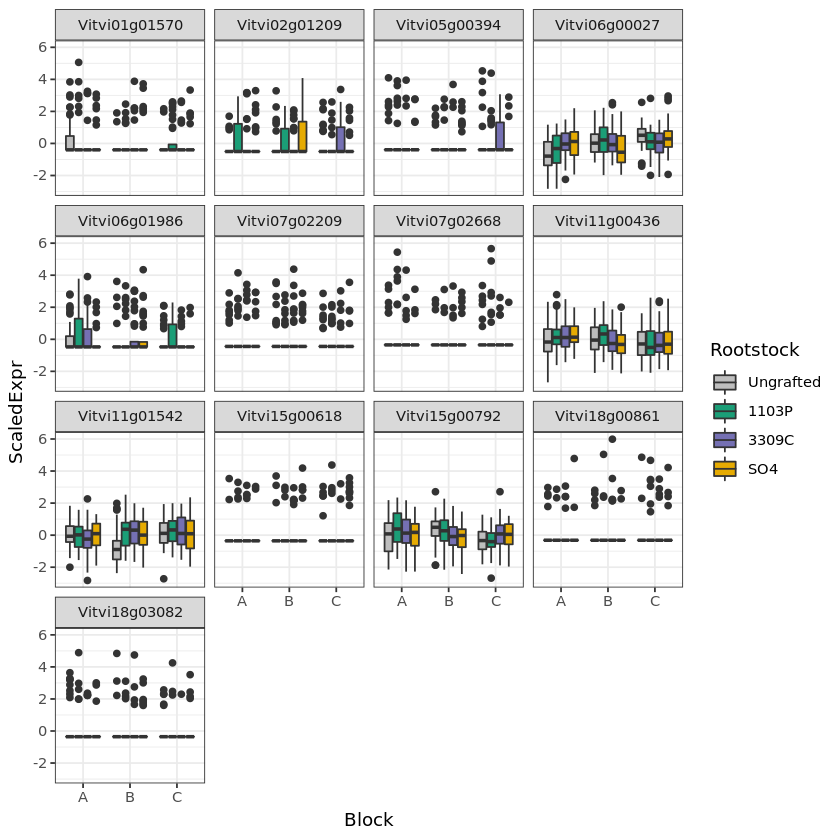

In [66]:
x <- as.character(unlist(sigGenes$Rootstock.Block_p))

to_plot <- vsd_counts_varFilt %>% select(x)
to_plot_scale <- as.data.frame(scale(to_plot, center=T, scale=T))
to_plot_scale$sampleName <- rownames(to_plot)
to_plot_scale <- merge(to_plot_scale, select(treatments, sampleName, Rootstock, Block))

to_plot_scale_long <- to_plot_scale %>% tidyr::gather("gene", "ScaledExpr", x[1]:x[length(x)])
dim(to_plot_scale_long)

ggplot(to_plot_scale_long, aes(x=Block, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_wrap('gene') + 
  theme_bw()

[1] 3816    5

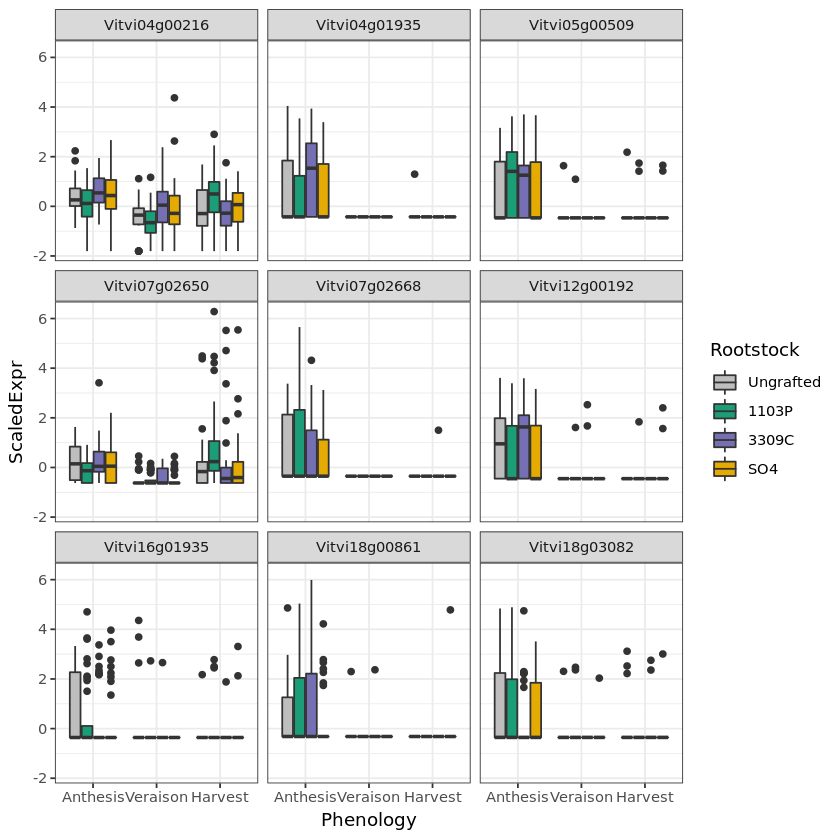

In [67]:
x <- as.character(unlist(sigGenes$Phenology.Rootstock_p))

to_plot <- vsd_counts_varFilt %>% select(x)
to_plot_scale <- as.data.frame(scale(to_plot, center=T, scale=T))
to_plot_scale$sampleName <- rownames(to_plot)
to_plot_scale <- merge(to_plot_scale, select(treatments, sampleName, Rootstock, Phenology))

to_plot_scale_long <- to_plot_scale %>% tidyr::gather("gene", "ScaledExpr", x[1]:x[length(x)])
dim(to_plot_scale_long)

ggplot(to_plot_scale_long, aes(x=Phenology, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_wrap('gene') + 
  theme_bw()

[1] 1272    5

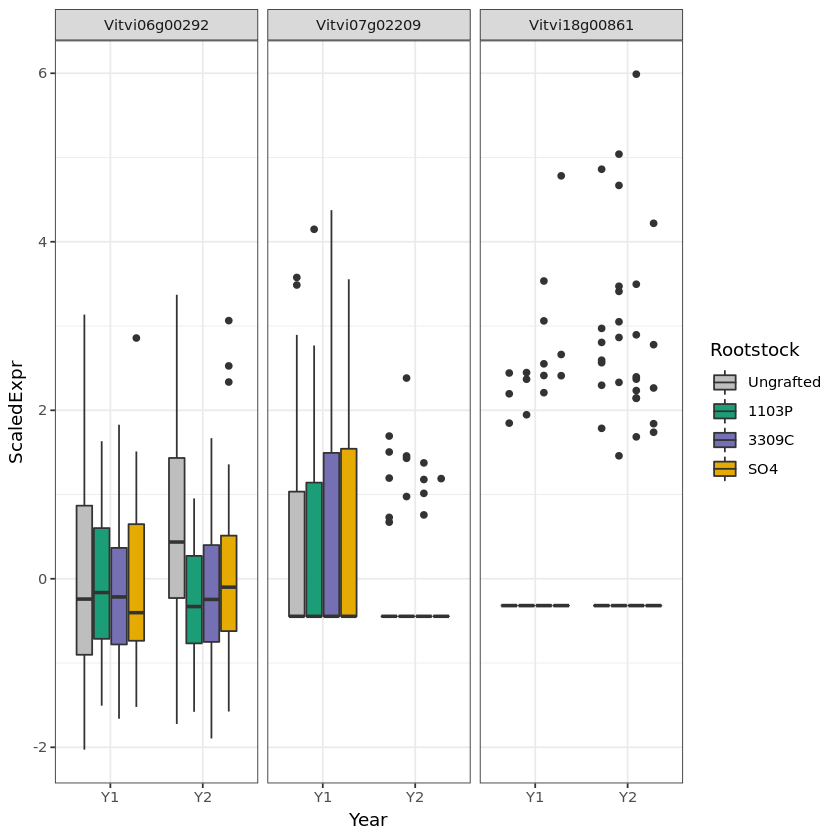

In [68]:
x <- as.character(unlist(sigGenes$Year.Rootstock_p))

to_plot <- vsd_counts_varFilt %>% select(x)
to_plot_scale <- as.data.frame(scale(to_plot, center=T, scale=T))
to_plot_scale$sampleName <- rownames(to_plot)
to_plot_scale <- merge(to_plot_scale, select(treatments, sampleName, Rootstock, Year))

to_plot_scale_long <- to_plot_scale %>% tidyr::gather("gene", "ScaledExpr", x[1]:x[length(x)])
dim(to_plot_scale_long)

ggplot(to_plot_scale_long, aes(x=Year, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_wrap('gene') + 
  theme_bw()

[1] 5936    6

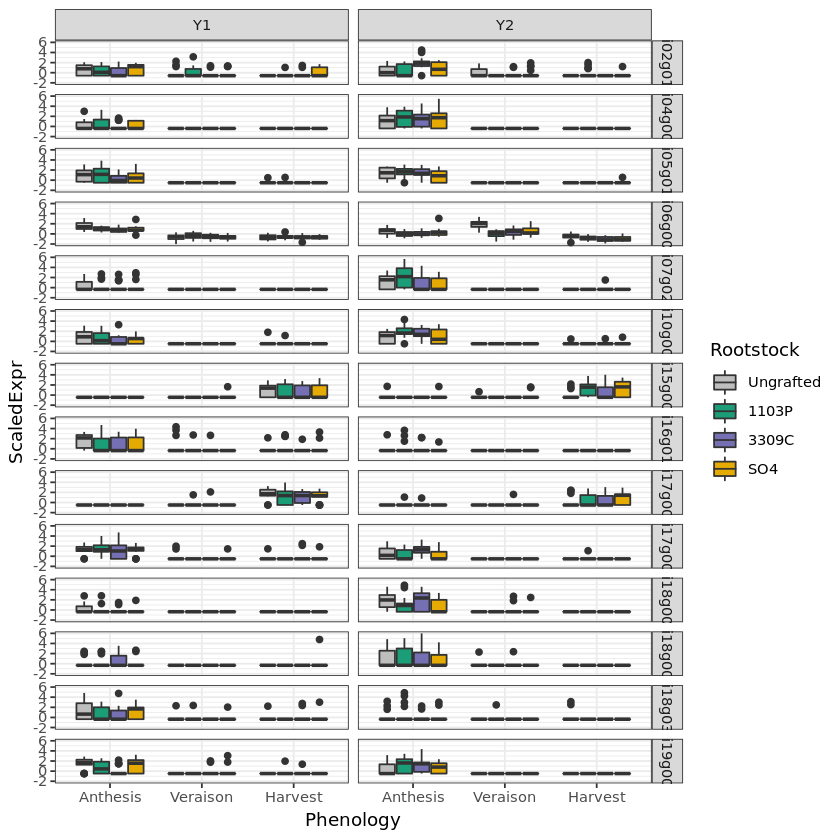

In [70]:
x <- as.character(unlist(sigGenes$Year.Phenology.Rootstock_p))

to_plot <- vsd_counts_varFilt %>% select(x)
to_plot_scale <- as.data.frame(scale(to_plot, center=T, scale=T))
to_plot_scale$sampleName <- rownames(to_plot)
to_plot_scale <- merge(to_plot_scale, select(treatments, sampleName, Rootstock, Phenology, Year))

to_plot_scale_long <- to_plot_scale %>% tidyr::gather("gene", "ScaledExpr", x[1]:x[length(x)])
dim(to_plot_scale_long)

ggplot(to_plot_scale_long, aes(x=Phenology, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_grid(rows=vars(gene), cols=vars(Year)) + 
  theme_bw()

[1] 6784    6

png 
  2

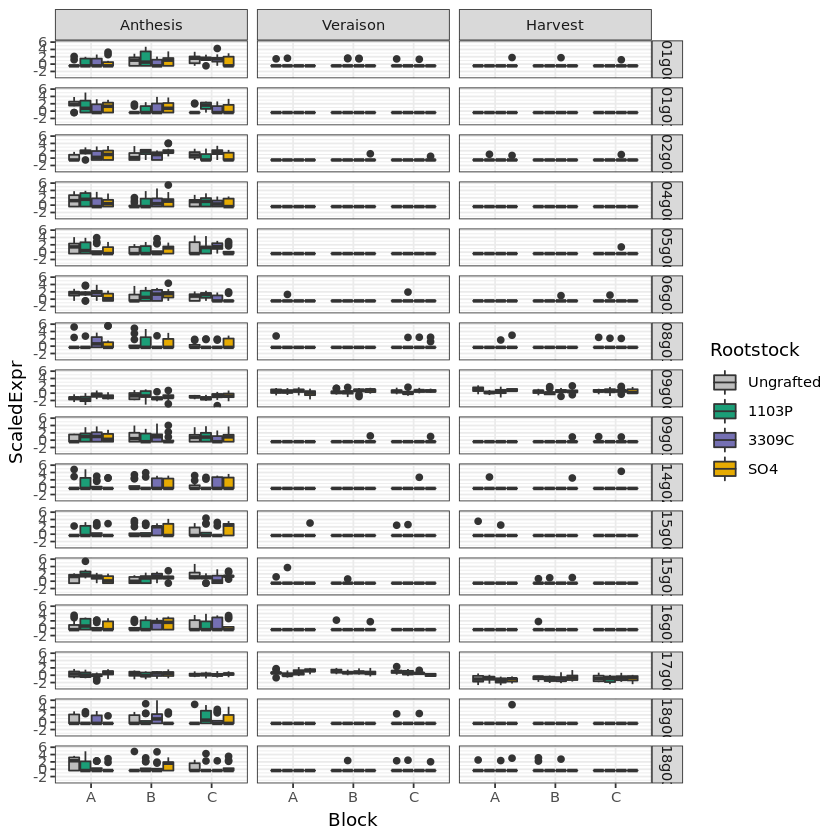

In [74]:
x <- as.character(unlist(sigGenes$Phenology.Rootstock.Block_p))

to_plot <- vsd_counts_varFilt %>% select(x)
to_plot_scale <- as.data.frame(scale(to_plot, center=T, scale=T))
to_plot_scale$sampleName <- rownames(to_plot)
to_plot_scale <- merge(to_plot_scale, select(treatments, sampleName, Rootstock, Phenology, Block))

to_plot_scale_long <- to_plot_scale %>% tidyr::gather("gene", "ScaledExpr", x[1]:x[length(x)])
dim(to_plot_scale_long)

p <- ggplot(to_plot_scale_long, aes(x=Block, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_grid(rows=vars(gene), cols=vars(Phenology)) + 
  theme_bw()

p

pdf('1718_geneExpression_PRB_byGene.pdf', height=24, width=8)
  p 
dev.off()

In [ ]:
x <- as.character(unlist(sigGenes$Year.Phenology.Rootstock.Block_p))

to_plot <- vsd_counts_varFilt %>% select(x)
to_plot_scale <- as.data.frame(scale(to_plot, center=T, scale=T))
to_plot_scale$sampleName <- rownames(to_plot)
to_plot_scale <- merge(to_plot_scale, select(treatments, sampleName, Rootstock, Phenology, Block, Year))

to_plot_scale_long <- to_plot_scale %>% tidyr::gather("gene", "ScaledExpr", x[1]:x[length(x)])
dim(to_plot_scale_long)

to_plot_scale_long17 <- to_plot_scale_long[to_plot_scale_long$Year == 'Y1',]
to_plot_scale_long18 <- to_plot_scale_long[to_plot_scale_long$Year == 'Y2',]

p1 <- ggplot(to_plot_scale_long17, aes(x=Block, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_grid(rows=vars(gene), cols=vars(Phenology)) + 
  theme_bw()

p2 <- ggplot(to_plot_scale_long18, aes(x=Block, y=ScaledExpr, fill=Rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual(values=rs_palette) + 
  facet_grid(rows=vars(gene), cols=vars(Phenology)) + 
  theme_bw()

In [77]:
pdf('1718_geneExpression_YPRB_byGene.pdf', height=104, width=8)
  ggpubr::ggarrange(p1, p2, ncol=2, common.legend=T, legend=F) 
dev.off()

png 
  2

In [58]:
d1 <- c(1, 2, 3)
d2 <- c(3, 4, 5)

intersect(d1, d2)
union(d1, d2)
setdiff(d1, d2)
setdiff(d2, d1)

[1] 3

[1] 1 2 3 4 5

[1] 1 2

[1] 4 5